# 03. CNN的搭建
> 🔑 **Note:** In deep learning, many different kinds of model architectures can be used for different problems. For example, you could use a convolutional neural network for making predictions on image data and/or text data. However, in practice some architectures typically work better than others.

For example, you might want to:
* Classify whether a picture of food contains pizza 🍕 or steak 🥩 (we're going to do this)
* Detect whether or not an object appears in an image (e.g. did a specific car pass through a security camera?)

## What we're going to cover，学那个几个方面

Specifically, we're going to go through the follow with TensorFlow:

- Getting a dataset to work with
- Architecture of a convolutional neural network
- A quick end-to-end example (what we're working towards)
- Steps in modelling for binary image classification with CNNs
  - Becoming one with the data
  - Preparing data for modelling
  - Creating a CNN model (starting with a baseline)
  - Fitting a model (getting it to find patterns in our data)
  - Evaluating a model
  - Improving a model
  - Making a prediction with a trained model
- Steps in modelling for multi-class image classification with CNNs
 - Same as above (but this time with a different dataset)

In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2025-01-06 10:18:29.423138


## Get the data 图片数据
The images we're going to work with are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes. 

To begin, we're only going to use two of the categories, pizza 🍕 and steak 🥩 and build a binary classifier.

> 🔑 **Note:** To prepare the data we're using, preprocessing steps such as, moving the images into different subset folders, have been done. To see these preprocessing steps check out [the preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

We'll download the `pizza_steak` subset .zip file and unzip it.

In [129]:
import zipfile
import os

# Download zip file of pizza_steak images
if not os.path.exists("pizza_steak.zip"):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

## Inspect the data (become one with it) 探索数据

More specifically:
* A `train` directory which contains all of the images in the training dataset with subdirectories each named after a certain class containing images of that class.
* A `test` directory with the same structure as the `train` directory.

```
Example of file structure

pizza_steak <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
 ```

Let's inspect each of the directories we've downloaded.

To so do, we can use the command `ls` which stands for list.

In [3]:
!ls pizza_steak

test  train


In [4]:
!ls pizza_steak/train/

pizza  steak


In [5]:
!ls pizza_steak/train/steak/

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [6]:
import os

# Walk through pizza_steak directory and list number of files，os查询文件夹和文件
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.


In [7]:
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
# 文件数量
num_steak_images_train

750

In [8]:
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [9]:
# 随机查看文件夹内的图片
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (384, 512, 3)


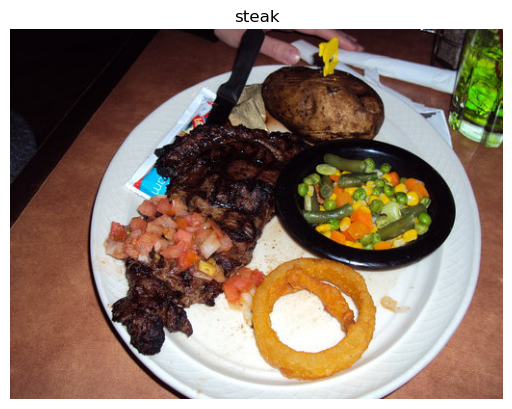

In [10]:
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

In [11]:
img

array([[[  8,   2,   6],
        [  8,   2,   6],
        [  8,   2,   6],
        ...,
        [ 56,  23,   4],
        [ 61,  28,   9],
        [100,  67,  48]],

       [[  8,   2,   6],
        [  8,   2,   6],
        [  8,   2,   6],
        ...,
        [ 50,  16,   6],
        [ 55,  18,  12],
        [ 80,  42,  41]],

       [[  8,   2,   6],
        [  8,   2,   6],
        [  8,   2,   6],
        ...,
        [ 53,  18,  16],
        [ 58,  18,  27],
        [ 59,  16,  33]],

       ...,

       [[105,  61,  48],
        [110,  66,  53],
        [116,  72,  59],
        ...,
        [137,  88,  74],
        [138,  89,  75],
        [138,  89,  75]],

       [[106,  62,  49],
        [111,  67,  54],
        [117,  73,  60],
        ...,
        [135,  86,  72],
        [136,  87,  73],
        [136,  87,  73]],

       [[107,  63,  50],
        [111,  67,  54],
        [116,  72,  59],
        ...,
        [135,  86,  72],
        [136,  87,  73],
        [136,  87,  73]]

In [12]:
img.shape  # (height, width, channels)

(384, 512, 3)

You'll notice all of the values in the `img` array are between 0 and 255. This is because that's the possible range for red, green and blue values.

For example, a pixel with a value `red=0, green=0, blue=255` will look very blue.

So when we build a model to differentiate between our images of `pizza` and `steak`, it will be finding patterns in these different pixel values which determine what each class looks like.

> 🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255.

In [13]:
# 0~1缩放
img/255

array([[[0.03137255, 0.00784314, 0.02352941],
        [0.03137255, 0.00784314, 0.02352941],
        [0.03137255, 0.00784314, 0.02352941],
        ...,
        [0.21960784, 0.09019608, 0.01568627],
        [0.23921569, 0.10980392, 0.03529412],
        [0.39215686, 0.2627451 , 0.18823529]],

       [[0.03137255, 0.00784314, 0.02352941],
        [0.03137255, 0.00784314, 0.02352941],
        [0.03137255, 0.00784314, 0.02352941],
        ...,
        [0.19607843, 0.0627451 , 0.02352941],
        [0.21568627, 0.07058824, 0.04705882],
        [0.31372549, 0.16470588, 0.16078431]],

       [[0.03137255, 0.00784314, 0.02352941],
        [0.03137255, 0.00784314, 0.02352941],
        [0.03137255, 0.00784314, 0.02352941],
        ...,
        [0.20784314, 0.07058824, 0.0627451 ],
        [0.22745098, 0.07058824, 0.10588235],
        [0.23137255, 0.0627451 , 0.12941176]],

       ...,

       [[0.41176471, 0.23921569, 0.18823529],
        [0.43137255, 0.25882353, 0.20784314],
        [0.45490196, 0

## CNN的网络结构


Components of a convolutional neural network:

| **Hyperparameter/Layer type** | **What does it do?** | **Typical values** |
| ----- | ----- | ----- |
| Input image(s) | Target images you'd like to discover patterns in| Whatever you can take a photo (or video) of |
| Input layer | Takes in target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution layer | Extracts/learns the most important features from target images | Multiple, can create with [`tf.keras.layers.ConvXD`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (X can be multiple values) |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU ([`tf.keras.activations.relu`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)) |
| Pooling layer | Reduces the dimensionality of learned image features | Average ([`tf.keras.layers.AvgPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)) or Max ([`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) |
| Fully connected layer | Further refines learned features from convolution layers | [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) |
| Output layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak or sushi)|
| Output activation | Adds non-linearities to output layer | [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) (binary classification) or [`tf.keras.activations.softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) |

How they stack together:

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-simple-convnet.png)
*A simple example of how you might stack together the above layers into a convolutional neural network. Note the convolutional and pooling layers can often be arranged and rearranged into many different formations.*

## An end-to-end example 端到端的模型

We've checked out our data and found there's 750 training images, as well as 250 test images per class and they're all of various different shapes. 

It's time to jump straight in the deep end.

Reading the [original dataset authors paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf), we see they used a [Random Forest machine learning model](https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d) and averaged 50.76% accuracy at predicting what different foods different images had in them.

From now on, that 50.76% will be our baseline.

> 🔑 **Note:** A **baseline** is a score or evaluation metric you want to try and beat. Usually you'll start with a simple model, create a baseline and try to beat it by increasing the complexity of the model. A really fun way to learn machine learning is to find some kind of modelling paper with a published result and try to beat it.

The code in the following cell replicates and end-to-end way to model our `pizza_steak` dataset with a convolutional neural network (CNN) using the components listed above.

There will be a bunch of things you might not recognize but step through the code yourself and see if you can figure out what it's doing.

We'll go through each of the steps later on in the notebook.

For reference, the model we're using replicates TinyVGG, the computer vision architecture which fuels the [CNN explainer webpage](https://poloclub.github.io/cnn-explainer/).

> 📖 **Resource:** The architecture we're using below is a scaled-down version of [VGG-16](https://arxiv.org/abs/1505.06798), a convolutional neural network which came 2nd in the 2014 [ImageNet classification competition](http://image-net.org/).

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history1 = model1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

2025-01-06 10:18:36.393306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-06 10:18:36.393330: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


2025-01-06 10:18:37.587759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-01-06 10:18:37.587782: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-01-06 10:18:37.587793: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iv-yddi5wlhj4qc6il2vxqe): /proc/driver/nvidia/version does not exist
2025-01-06 10:18:37.587943: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
47/47 [==============================] - 21s 444ms/step - loss: 0.6458 - accuracy: 0.5967 - val_loss: 0.5388 - val_accuracy: 0.7400
Epoch 2/5
47/47 [==============================] - 20s 424ms/step - loss: 0.4707 - accuracy: 0.7953 - val_loss: 0.3905 - val_accuracy: 0.8360
Epoch 3/5
47/47 [==============================] - 20s 422ms/step - loss: 0.4146 - accuracy: 0.8180 - val_loss: 0.3335 - val_accuracy: 0.8620
Epoch 4/5
47/47 [==============================] - 20s 424ms/step - loss: 0.3645 - accuracy: 0.8487 - val_loss: 0.3298 - val_accuracy: 0.8560
Epoch 5/5
47/47 [==============================] - 20s 422ms/step - loss: 0.3410 - accuracy: 0.8573 - val_loss: 0.2989 - val_accuracy: 0.8660


In [15]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [16]:
import pandas as pd
pd.DataFrame(history1.history)

loss  accuracy  val_loss  val_accuracy
0  0.645780  0.596667  0.538828         0.740
1  0.470715  0.795333  0.390519         0.836
2  0.414553  0.818000  0.333484         0.862
3  0.364509  0.848667  0.329842         0.856
4  0.341043  0.857333  0.298895         0.866

What do you notice about the names of `model_1`'s layers and the layer names at the top of the [CNN explainer website](https://poloclub.github.io/cnn-explainer/)?

I'll let you in on a little secret: we've replicated the exact architecture they use for their model demo.

Look at you go! **You're already starting to replicate models you find in the wild.**

Now there are a few new things here we haven't discussed, namely: 
* The [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class and the `rescale` parameter
* The [`flow_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method
  * The `batch_size` parameter
  * The `target_size` parameter
* [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers (and the parameters which come with them)
* [`MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers (and their parameters).
* The `steps_per_epoch` and `validation_steps` parameters in the `fit()` function

Before we dive into each of these, let's see what happens if we try to fit a model we've worked with previously to our data.

## Using the same model as before,

To examplify how neural networks can be adapted to many different problems, let's see how a binary classification model we've previously built might work with our data.

> 🔑 **Note:** If you haven't gone through the previous classification notebook, no troubles, we'll be bringing in the a simple 4 layer architecture used to separate dots replicated from the [TensorFlow Playground environment](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.75075&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

We can use all of the same parameters in our previous model except for changing two things:
* **The data** - we're now working with images instead of dots.
* **The input shape** - we have to tell our neural network the shape of the images we're working with.
  * A common practice is to reshape images all to one size. In our case, we'll resize the images to `(224, 224, 3)`, meaning a height and width of 224 pixels and a depth of 3 for the red, green, blue colour channels.
  
用之前的模型，要做出两处修改
一是，数据是图片，不是点
二是输入层的形状，要告诉模型我们的输入数据的形状

In [17]:
tf.random.set_seed(42)

model2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history2 = model2.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=valid_data,
                      validation_steps=len(valid_data))


Epoch 1/5
47/47 [==============================] - 7s 139ms/step - loss: 0.9640 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 6s 134ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 6s 135ms/step - loss: 0.6932 - accuracy: 0.4653 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 6s 134ms/step - loss: 0.6932 - accuracy: 0.4880 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 6s 136ms/step - loss: 0.6932 - accuracy: 0.4920 - val_loss: 0.6931 - val_accuracy: 0.5000


In [18]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 64)                9633856   
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 9,634,121
Trainable params: 9,634,121
Non-trainable params: 0
_________________________________________________________________


In [19]:
pd.DataFrame(history2.history)

loss  accuracy  val_loss  val_accuracy
0  0.963964  0.502667  0.693148           0.5
1  0.693205  0.500000  0.693150           0.5
2  0.693187  0.465333  0.693147           0.5
3  0.693161  0.488000  0.693147           0.5
4  0.693162  0.492000  0.693148           0.5

`model_2` has 602,141 trainable parameters where as `model_1` has only 31,101. And despite this difference, `model_1` still far and large out performs `model_2`.

> 🔑 **Note:** You can think of trainable parameters as *patterns a model can learn from data*. Intuitiely, you might think more is better. And in some cases it is. But in this case, the difference here is in the two different styles of model we're using. Where a series of dense layers have a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, **a convolutional neural network seeks to sort out and learn the most important patterns in an image**. So even though there are less learnable parameters in our convolutional neural network, these are often more helpful in decphering between different **features** in an image.

Since our previous model didn't work, do you have any ideas of how we might make it work?

How about we increase the number of layers? 

And maybe even increase the number of neurons in each layer?

More specifically, we'll increase the number of neurons (also called hidden units) in each dense layer from 4 to 100 and add an extra layer.

> 🔑 **Note:** Adding extra layers or increasing the number of neurons in each layer is often referred to as increasing the **complexity** of your model.

模型2的参数要比模型1大很多，但是模型2的准确率要低，因为cnn模型可以更换捕获，发现规律
即使继续增加模型2的网络层数和大小，效果有提升，但是还是比不了cnn

In [20]:
tf.random.set_seed(42)

model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(1000, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model3.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history3 = model3.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=valid_data,
                      validation_steps=len(valid_data))


Epoch 1/5
47/47 [==============================] - 12s 246ms/step - loss: 15.2759 - accuracy: 0.6053 - val_loss: 2.4723 - val_accuracy: 0.6400
Epoch 2/5
47/47 [==============================] - 11s 242ms/step - loss: 1.5201 - accuracy: 0.6947 - val_loss: 0.7256 - val_accuracy: 0.7340
Epoch 3/5
47/47 [==============================] - 11s 242ms/step - loss: 1.5775 - accuracy: 0.6893 - val_loss: 2.7580 - val_accuracy: 0.5760
Epoch 4/5
47/47 [==============================] - 11s 242ms/step - loss: 0.8175 - accuracy: 0.7480 - val_loss: 0.6257 - val_accuracy: 0.7860
Epoch 5/5
47/47 [==============================] - 12s 243ms/step - loss: 0.6417 - accuracy: 0.7760 - val_loss: 0.9500 - val_accuracy: 0.6520


In [21]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 1000)              150529000 
                                                                 
 dense_5 (Dense)             (None, 100)               100100    
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 150,639,301
Trainable params: 150,639,301
Non-trainable params: 0
_________________________________________________________________


In [22]:
pd.DataFrame(history3.history)

loss  accuracy  val_loss  val_accuracy
0  15.275942  0.605333  2.472348         0.640
1   1.520127  0.694667  0.725569         0.734
2   1.577492  0.689333  2.757987         0.576
3   0.817527  0.748000  0.625731         0.786
4   0.641714  0.776000  0.950048         0.652

## Binary classification: Let's break it down  二分类算法

We just went through a whirlwind of steps:

1. Become one with the data (visualize, visualize, visualize...) 可视化数据
2. Preprocess the data (prepare it for a model)  数据处理
3. Create a model (start with a baseline) 模型创建
4. Fit the model 模型训练
5. Evaluate the model 模型评估
6. Adjust different parameters and improve model (try to beat your baseline) 模型调参
7. Repeat until satisfied 循环

Let's step through each.

### 1. Import and become one with the data 熟悉数据
> 📖 **Resource:** To see how this data was processed into the file format we're using, see the [preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

In [ ]:
# import zipfile

# # Download zip file of pizza_steak images
# !epochs=5 https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# # Unzip the downloaded file
# zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

Image shape: (512, 512, 3)
Image shape: (382, 512, 3)


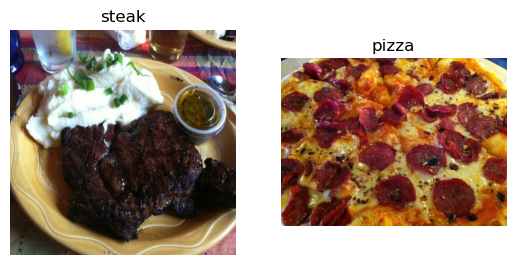

In [24]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

### 2. Preprocess the data (prepare it for a model)  数据处理
划分训练集和测试集

In [25]:
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

Our next step is to turn our data into **batches**.将数据批量化

It does this for a couple of reasons:
* 10,000 images (or more) might not fit into the memory of your processor (GPU).
* Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

It does this for a couple of reasons:
* 10,000 images (or more) might not fit into the memory of your processor (GPU).
* Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

32 是个经验值，用的比较多

Why 32?

c
No seriously, there are many different batch sizes you could use but 32 has proven to be very effective in many different use cases and is often the default for many data preprocessing functions.

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

The `rescale` parameter, along with `1/255.` is like saying "divide all of the pixel values by 255". This results in all of the image being imported and their pixel values being normalized (converted to be between 0 and 1).除以255，使图像中的所有像素值归一化（转换为0和1之间）

> 🔑 **Note:** For more transformation options such as data augmentation (we'll see this later), refer to the [`ImageDataGenerator` documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

Now we've got a couple of ImageDataGenerator instances, we can load our images from their respective directories using the [`flow_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method.

In [27]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Some things to here:
* Due to how our directories are structured, the classes get inferred by the subdirectory names in `train_dir` and `test_dir`. 目录
* The `target_size` parameter defines the input size of our images in `(height, width)` format.宽高
* The `class_mode` value of `'binary'` defines our classification problem type. If we had more than two classes, we would use `'categorical'`. 分类方式
* The `batch_size` defines how many images will be in each batch, we've used 32 which is the same as the default. batch大小

We can take a look at our batched images and labels by inspecting the `train_data` object.

In [28]:
images ,labels = train_data.next()
type(images),images

(numpy.ndarray,
 array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.4784314 , 0.427451  , 0.3647059 ],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.8313726 , 0.70980394, 0.48627454],
          [0.8431373 , 0.73333335, 0.5372549 ],
          [0.87843144, 0.7725491 , 0.5882353 ]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.5058824 ],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.49411768],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
  

In [29]:
type(labels),labels

(numpy.ndarray,
 array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
       dtype=float32))

In [30]:
len(images),len(labels)

(32, 32)

In [31]:
images[1],images[1].shape

(array([[[0.38823533, 0.4666667 , 0.36078432],
         [0.3921569 , 0.46274513, 0.36078432],
         [0.38431376, 0.454902  , 0.36078432],
         ...,
         [0.5294118 , 0.627451  , 0.54509807],
         [0.5294118 , 0.627451  , 0.54509807],
         [0.5411765 , 0.6392157 , 0.5568628 ]],
 
        [[0.38431376, 0.454902  , 0.3529412 ],
         [0.3921569 , 0.46274513, 0.36078432],
         [0.39607847, 0.4666667 , 0.37254903],
         ...,
         [0.54509807, 0.6431373 , 0.5686275 ],
         [0.5529412 , 0.6509804 , 0.5764706 ],
         [0.5647059 , 0.6627451 , 0.5882353 ]],
 
        [[0.3921569 , 0.46274513, 0.36078432],
         [0.38431376, 0.454902  , 0.3529412 ],
         [0.4039216 , 0.47450984, 0.3803922 ],
         ...,
         [0.5764706 , 0.67058825, 0.6156863 ],
         [0.5647059 , 0.6666667 , 0.6156863 ],
         [0.5647059 , 0.6666667 , 0.6156863 ]],
 
        ...,
 
        [[0.47058827, 0.5647059 , 0.4784314 ],
         [0.4784314 , 0.5764706 , 0.49019

In [32]:
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

### 3. Create a model (start with a baseline)  建立模型，采用基准模型
You might be wondering what your default model architecture should be.

And the truth is, there's many possible answers to this question.

A simple heuristic for computer vision models is to use the model architecture which is performing best on [ImageNet](https://www.image-net.org/) (a large collection of diverse images to benchmark different computer vision models).

However, to begin with, it's good to build a smaller model to acquire a baseline result which you try to improve upon.

> 🔑 **Note:** In deep learning a smaller model often refers to a model with less layers than the state of the art (SOTA). For example, a smaller model might have 3-4 layers where as a state of the art model, such as, ResNet50 might have 50+ layers.

In [33]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [34]:
model4 = Sequential([
    Conv2D(filters=10,kernel_size=3,strides=1,padding='valid',activation='relu',input_shape=(224,224,3)),
    Conv2D(10,3,activation='relu'),
    Conv2D(10,3,activation='relu'),
    Flatten(),
    Dense(1,activation='sigmoid')
]
)

model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [35]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### 4. Fit a model
You'll notice two new parameters here:
* `steps_per_epoch` - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of `train_data` (1500 images in batches of 32 = 1500/32 = ~47 steps)
* `validation_steps` - same as above, except for the `validation_data` parameter (500 test images in batches of 32 = 500/32 = ~16 steps)

In [36]:
len(train_data),len(test_data)

(47, 16)

In [ ]:
history4 = model4.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data))

Epoch 1/10
47/47 [==============================] - 24s 500ms/step - loss: 1.5551 - accuracy: 0.6640 - val_loss: 0.4445 - val_accuracy: 0.8020
Epoch 2/10
47/47 [==============================] - 24s 499ms/step - loss: 0.4394 - accuracy: 0.8080 - val_loss: 0.4075 - val_accuracy: 0.8120
Epoch 3/10
47/47 [==============================] - 24s 500ms/step - loss: 0.3332 - accuracy: 0.8653 - val_loss: 0.3757 - val_accuracy: 0.8400
Epoch 4/10
47/47 [==============================] - 24s 501ms/step - loss: 0.1895 - accuracy: 0.9353 - val_loss: 0.4114 - val_accuracy: 0.8260
Epoch 5/10
47/47 [==============================] - 25s 526ms/step - loss: 0.0852 - accuracy: 0.9787 - val_loss: 0.4917 - val_accuracy: 0.8040
Epoch 6/10
47/47 [==============================] - 24s 511ms/step - loss: 0.0301 - accuracy: 0.9947 - val_loss: 0.6507 - val_accuracy: 0.8020
Epoch 7/10
47/47 [==============================] - 24s 507ms/step - loss: 0.0298 - accuracy: 0.9933 - val_loss: 0.5565 - val_accuracy: 0.8040

### 5. Evaluate the model

<Axes: >

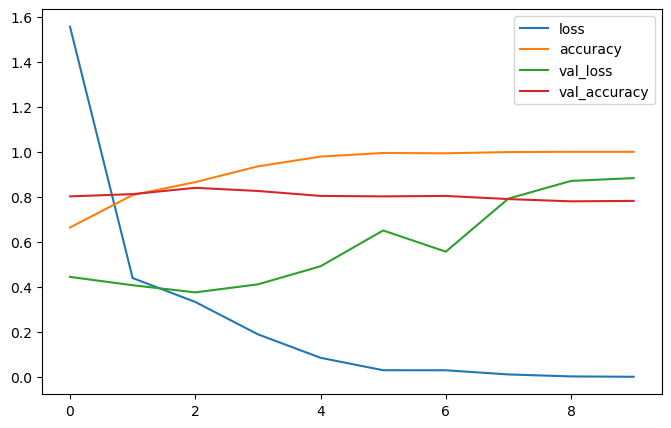

In [38]:
pd.DataFrame(history4.history).plot(figsize=(8, 5))


In [39]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

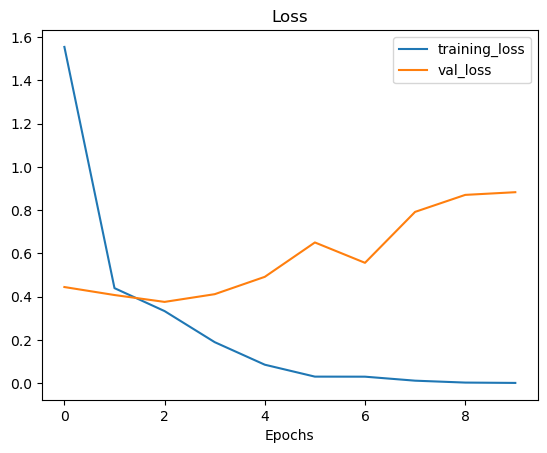

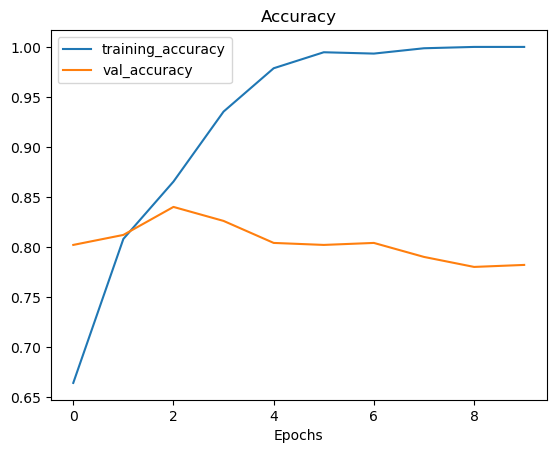

In [40]:
plot_loss_curves(history4)

mm, judging by our loss curves, it looks like our model is **overfitting** the training dataset.

> 🔑 **Note:** When a model's **validation loss starts to increase**, it's likely that it's overfitting the training dataset. This means, it's learning the patterns in the training dataset *too well* and thus its ability to generalize to unseen data will be diminished.

有点过拟合了

### 6. Adjust the model parameters

模型架构优化的三步：1. 构建一个基础模型；2. 构建一个较大的模型，并尝试过拟合；3. 减少过拟合。

Fitting a machine learning model  comes in 3 steps:
0. Create a basline.
1. Beat the baseline by overfitting a larger model.
2. Reduce overfitting.

So far we've gone through steps 0 and 1.

And there are even a few more things we could try to further overfit our model:
* Increase the number of convolutional layers.
* Increase the number of convolutional filters.
* Add another dense layer to the output of our flattened layer.

But what we'll do instead is focus on getting our model's training curves to better align with eachother, in other words, we'll take on step 2.

Why is reducing overfitting important?

When a model performs too well on training data and poorly on unseen data, it's not much use to us if we wanted to use it in the real world.

Say we were building a pizza vs. steak food classifier app, and our model performs very well on our training data but when users tried it out, they didn't get very good results on their own food images, is that a good experience?

Not really...

So for the next few models we build, we're going to adjust a number of parameters and inspect the training curves along the way.

Namely, we'll build 2 more models: 利用最大池化，和数据增强测试效果
* A ConvNet with [max pooling](https://deeplizard.com/learn/video/ZjM_XQa5s6s)
* A ConvNet with max pooling and data augmentation

For the first model, we'll follow the modified basic CNN structure:

```
Input -> Conv layers + ReLU layers (non-linearities) + Max Pooling layers -> Fully connected (dense layer) as Output
```

Let's built it. It'll have the same structure as `model_4` but with a [`MaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layer after each convolutional layer.

In [41]:
model5 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid'),
])

In [42]:
model5.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data))

Epoch 1/10
47/47 [==============================] - 11s 222ms/step - loss: 0.6014 - accuracy: 0.6827 - val_loss: 0.4351 - val_accuracy: 0.8220
Epoch 2/10
47/47 [==============================] - 10s 217ms/step - loss: 0.4553 - accuracy: 0.8007 - val_loss: 0.4364 - val_accuracy: 0.7880
Epoch 3/10
47/47 [==============================] - 10s 218ms/step - loss: 0.4177 - accuracy: 0.8147 - val_loss: 0.3484 - val_accuracy: 0.8540
Epoch 4/10
47/47 [==============================] - 10s 218ms/step - loss: 0.4026 - accuracy: 0.8253 - val_loss: 0.3267 - val_accuracy: 0.8720
Epoch 5/10
47/47 [==============================] - 10s 217ms/step - loss: 0.3561 - accuracy: 0.8527 - val_loss: 0.3042 - val_accuracy: 0.8860
Epoch 6/10
47/47 [==============================] - 10s 217ms/step - loss: 0.3530 - accuracy: 0.8567 - val_loss: 0.3411 - val_accuracy: 0.8560
Epoch 7/10
47/47 [==============================] - 10s 218ms/step - loss: 0.3180 - accuracy: 0.8680 - val_loss: 0.3221 - val_accuracy: 0.8540

In [44]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

<Axes: >

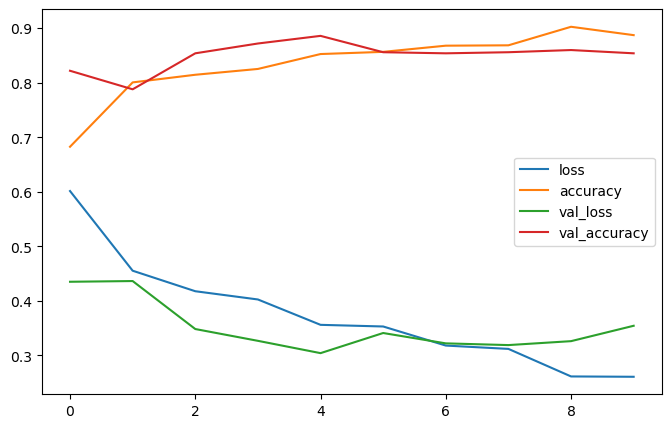

In [45]:
pd.DataFrame(history5.history).plot(figsize=(8, 5))

Nice! We can see the training curves get a lot closer to eachother. However, our the validation loss looks to start increasing towards the end and in turn potentially leading to overfitting.

池化技术明显降低了过拟合，再尝试数据增强

Time to dig into our bag of tricks and try another method of overfitting prevention, data augmentation. 

First, we'll see how it's done with code then we'll discuss what it's doing.

To implement data augmentation, we'll have to reinstantiate our [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instances.

In [46]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

*Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

Doing this simulates the kind of data a model might be used on in the real world.

If we're building a pizza vs. steak application, not all of the images our users take might be in similar setups to our training data. Using data augmentation gives us another way to prevent overfitting and in turn make our model more generalizable.

> 🔑 **Note:** Data augmentation is usally only performed on the training data. Using the `ImageDataGenerator` built-in data augmentation parameters our images are left as they are in the directories but are randomly manipulated when loaded into the model.

In [47]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [48]:
# 获取数据案例
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

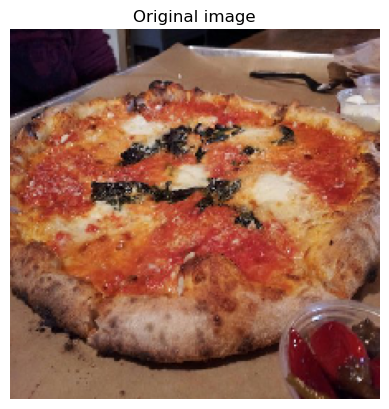

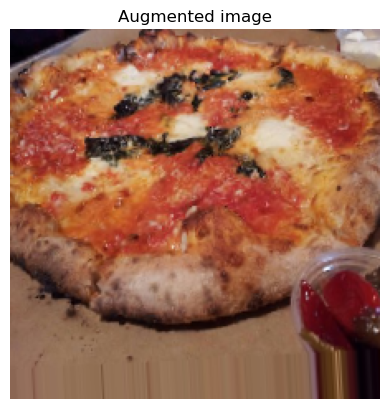

In [49]:
# Show original image and augmented image
random_number = random.randint(0, 31) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

数据增强的数据，要增强多少没有定论，只能多尝试，而且最适合图片数据

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

As for how much to data augment, there's no set practice for this. Best to check out the options in the `ImageDataGenerator` class and think about how a model in your use case might benefit from some data augmentation.

Now we've got augmented data, let's try and refit a model on it and see how it affects training.

We'll use the same model as `model_5`.

In [ ]:
model6 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid'),
])

model6.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history6 = model6.fit(train_data_augmented,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data))

Epoch 1/10
47/47 [==============================] - 19s 388ms/step - loss: 0.7033 - accuracy: 0.5707 - val_loss: 0.9620 - val_accuracy: 0.5000
Epoch 2/10
47/47 [==============================] - 18s 387ms/step - loss: 0.7588 - accuracy: 0.5687 - val_loss: 0.6816 - val_accuracy: 0.5580
Epoch 3/10
37/47 [======================>.......] - ETA: 3s - loss: 0.6904 - accuracy: 0.5398

47/47 [==============================] - 18s 385ms/step - loss: 0.6878 - accuracy: 0.5673 - val_loss: 0.6688 - val_accuracy: 0.7140
Epoch 4/10
47/47 [==============================] - 18s 383ms/step - loss: 0.6727 - accuracy: 0.5960 - val_loss: 0.6322 - val_accuracy: 0.7080
Epoch 5/10
47/47 [==============================] - 18s 390ms/step - loss: 0.6584 - accuracy: 0.6113 - val_loss: 0.5956 - val_accuracy: 0.7180
Epoch 6/10
47/47 [==============================] - 18s 381ms/step - loss: 0.7197 - accuracy: 0.5473 - val_loss: 0.6584 - val_accuracy: 0.6500
Epoch 7/10
47/47 [==============================] - 18s 385ms/step - loss: 0.6545 - accuracy: 0.6407 - val_loss: 0.5657 - val_accuracy: 0.7360
Epoch 8/10
47/47 [==============================] - 18s 383ms/step - loss: 0.6173 - accuracy: 0.6873 - val_loss: 0.4839 - val_accuracy: 0.8100
Epoch 9/10
47/47 [==============================] - 18s 385ms/step - loss: 0.5813 - accuracy: 0.7153 - val_loss: 0.4999 - val_accuracy: 0.7380
Epoch 10/1

> 🤔 **Question:** Why didn't our model get very good results on the training set to begin with?

模型效果变差了，是因为训练数据集没有打乱，也就是每次训练都只加载一个类别的数据，导致模型效果变差。数据打乱很重要

It's because when we created `train_data_augmented` we turned off data shuffling using `shuffle=False` which means our model only sees a batch of a single kind of images at a time. 

For example, the pizza class gets loaded in first because it's the first class. Thus it's performance is measured on only a single class rather than both classes. The validation data performance improves steadily because it contains shuffled data.

Since we only set `shuffle=False` for demonstration purposes (so we could plot the same augmented and non-augmented image), we can fix this by setting `shuffle=True` on future data generators.

You may have also noticed each epoch taking longer when training with augmented data compared to when training with non-augmented data (~25s per epoch vs. ~10s per epoch).

This is because the `ImageDataGenerator` instance augments the data as it's loaded into the model. The benefit of this is that it leaves the original images unchanged. The downside is that it takes longer to load them in.

> 🔑 **Note:** One possible method to speed up dataset manipulation would be to look into [TensorFlow's parrallel reads and buffered prefecting options](https://www.tensorflow.org/tutorials/images/data_augmentation).

<Axes: >

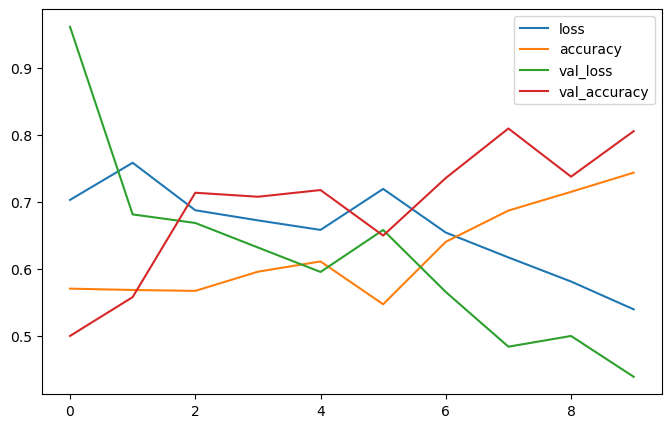

In [51]:
pd.DataFrame(history6.history).plot(figsize=(8, 5))

训练过程中，测试集的准确率有所波动，有下降的时候，不够平滑，尝试将数据打乱

It seems our validation loss curve is heading in the right direction but it's a bit jumpy (the most ideal loss curve isn't too spiky but a smooth descent, however, a perfectly smooth loss curve is the equivalent of a fairytale).

Let's see what happens when we shuffle the augmented training data.

In [52]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 1500 images belonging to 2 classes.


In [ ]:
model7 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid'),
])

model7.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history7 = model7.fit(train_data_augmented_shuffled,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data))

Epoch 1/10
47/47 [==============================] - 19s 388ms/step - loss: 0.6304 - accuracy: 0.6253 - val_loss: 0.4682 - val_accuracy: 0.7800
Epoch 2/10
47/47 [==============================] - 18s 384ms/step - loss: 0.5072 - accuracy: 0.7573 - val_loss: 0.3640 - val_accuracy: 0.8480
Epoch 3/10
47/47 [==============================] - 18s 386ms/step - loss: 0.4820 - accuracy: 0.7687 - val_loss: 0.4324 - val_accuracy: 0.7900
Epoch 4/10
47/47 [==============================] - 18s 386ms/step - loss: 0.4626 - accuracy: 0.7833 - val_loss: 0.3353 - val_accuracy: 0.8560
Epoch 5/10
47/47 [==============================] - 18s 385ms/step - loss: 0.4671 - accuracy: 0.7853 - val_loss: 0.3728 - val_accuracy: 0.8360
Epoch 6/10
47/47 [==============================] - 18s 388ms/step - loss: 0.4424 - accuracy: 0.8007 - val_loss: 0.3967 - val_accuracy: 0.8140
Epoch 7/10
47/47 [==============================] - 18s 385ms/step - loss: 0.4480 - accuracy: 0.7973 - val_loss: 0.4306 - val_accuracy: 0.7980

<Axes: >

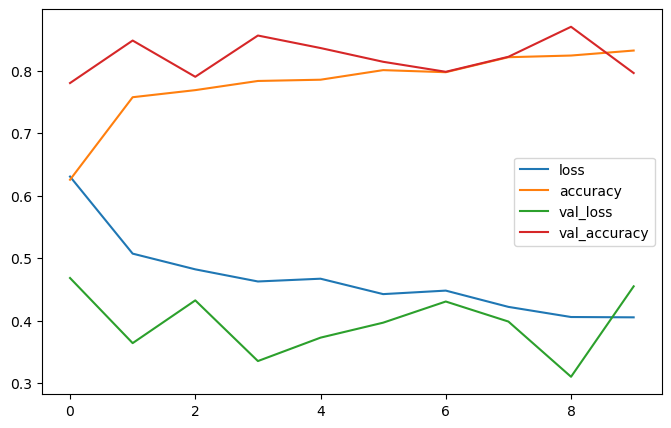

In [54]:
pd.DataFrame(history7.history).plot(figsize=(8, 5))

Notice with `model_7` how the performance on the training dataset improves almost immediately compared to `model_6`. This is because we shuffled the training data as we passed it to the model using the parameter `shuffle=True` in the `flow_from_directory` method.

This means the model was able to see examples of both pizza and steak images in each batch and in turn be evaluated on what it learned from both images rather than just one kind.

Also, our loss curves look a little bit smoother with shuffled data (comparing `history_6` to `history_7`).

数据打乱可以提高训练速度，并减少过拟合。

### 7. Repeat until satisified  循环优化 

继续优化的方法：1、增加层数 2、增加卷积核数量 3、增加训练轮数 4、寻找合适的学习率 5、获取更多的数据 6、使用预训练模型

We've trained a few model's on our dataset already and so far they're performing pretty good.

Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:
* Increase the number of model layers (e.g. add more convolutional layers).
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
* Train for longer (more epochs).
* Finding an ideal learning rate.
* Get more data (give the model more opportunities to learn).
* Use **transfer learning** to leverage what another image model has learned and adjust it for our own use case.

Adjusting each of these settings (except for the last two) during model development is usually referred to as **hyperparameter tuning**.

You can think of hyperparameter tuning as simialr to adjusting the settings on your oven to cook your favourite dish. Although your oven does most of the cooking for you, you can help it by tweaking the dials.

Let's go back to right where we started and try our original model (`model_1` or the TinyVGG architecture from [CNN explainer](https://poloclub.github.io/cnn-explainer/)).


In [ ]:
model8 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid'),
])

model8.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history8 = model8.fit(train_data_augmented_shuffled,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data))

Epoch 1/10
47/47 [==============================] - 22s 464ms/step - loss: 0.6296 - accuracy: 0.6567 - val_loss: 0.4960 - val_accuracy: 0.7800
Epoch 2/10
47/47 [==============================] - 22s 462ms/step - loss: 0.5350 - accuracy: 0.7553 - val_loss: 0.4095 - val_accuracy: 0.8420
Epoch 3/10
47/47 [==============================] - 22s 460ms/step - loss: 0.5251 - accuracy: 0.7487 - val_loss: 0.4309 - val_accuracy: 0.8080
Epoch 4/10
47/47 [==============================] - 22s 470ms/step - loss: 0.4997 - accuracy: 0.7707 - val_loss: 0.4699 - val_accuracy: 0.7840
Epoch 5/10
47/47 [==============================] - 22s 462ms/step - loss: 0.4930 - accuracy: 0.7720 - val_loss: 0.3667 - val_accuracy: 0.8460
Epoch 6/10
47/47 [==============================] - 22s 465ms/step - loss: 0.4471 - accuracy: 0.7947 - val_loss: 0.3200 - val_accuracy: 0.8660
Epoch 7/10
47/47 [==============================] - 22s 456ms/step - loss: 0.4572 - accuracy: 0.7993 - val_loss: 0.3835 - val_accuracy: 0.8340

和model1，TinyVGG的模型结构相同,只是用了Conv2D和MaxPool2D替换了 tf.keras.layers.Conv2D,但背后的结构是一样的。

In [56]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [57]:
model8.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_17 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_19 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                 

<Axes: >

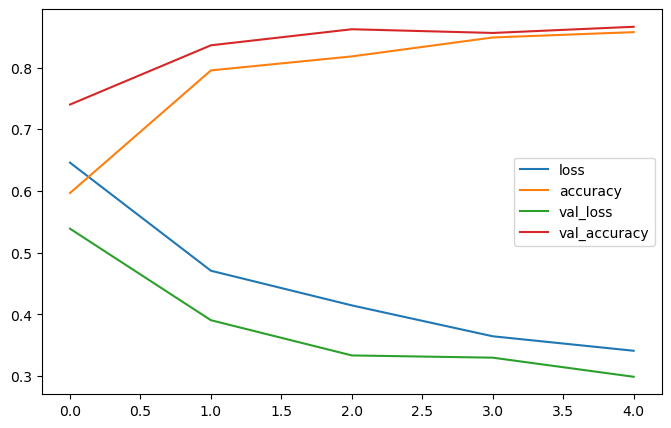

In [58]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))

<Axes: >

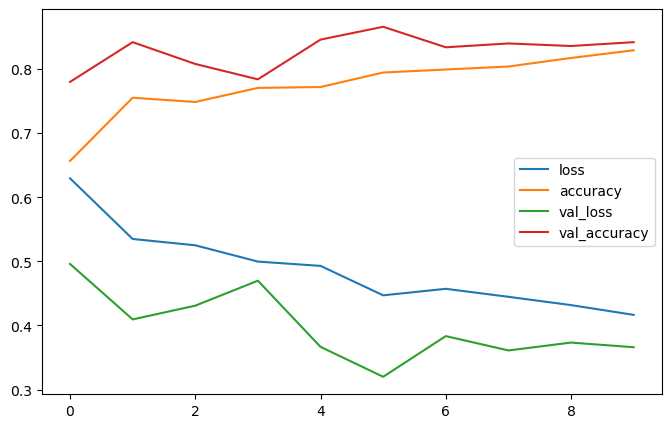

In [59]:
pd.DataFrame(history8.history).plot(figsize=(8, 5))

### Making a prediction with our trained model 模型预测，下载真实数据，评比效果

What good is a trained model if you can't make predictions with it?

To really test it out, we'll upload a couple of our own images and see how the model goes.

First, let's remind ourselves of the classnames and view the image we're going to test on.

In [60]:
print(class_names)

['pizza' 'steak']


--2025-01-06 10:37:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg.1’

03-steak.jpeg.1     100%[===================>]   1.89M   124KB/s    in 16s     

2025-01-06 10:44:38 (124 KB/s) - ‘03-steak.jpeg.1’ saved [1978213/1978213]



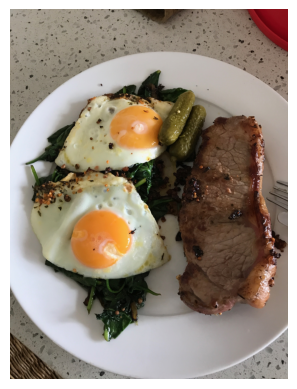

In [ ]:
if not os.path.exists("03-steak.jpeg"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [62]:
steak.shape

(4032, 3024, 3)

数据形状的改变

Since our model takes in images of shapes `(224, 224, 3)`, we've got to reshape our custom image to use it with our model.

To do so, we can import and decode our image using [`tf.io.read_file`](https://www.tensorflow.org/api_docs/python/tf/io/read_file) (for readining files) and [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) (for resizing our image and turning it into a tensor).

> 🔑 **Note:** For your model to make predictions on unseen data, for example, your own custom images, the custom image has to be in the same shape as your model has been trained on. In more general terms, to make predictions on custom data it has to be in the same form that your model has been trained on.

In [63]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [64]:
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

In [66]:
# model8.predict(steak)

需要添加个batch的维度

Well, the batch size becomes the first dimension.

So in reality, our model was trained on data in the shape of `(batch_size, 224, 224, 3)`.

We can fix this by adding an extra to our custom image tensor using [`tf.expand_dims`](https://www.tensorflow.org/api_docs/python/tf/expand_dims).

In [67]:
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0)
print(f"Shape after new dimension: {steak.shape}")

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


In [68]:
steak

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6377451 , 0.6220588 , 0.57892156],
         [0.6504902 , 0.63186276, 0.5897059 ],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.05098039, 0.09019608],
         [0.49509802, 0.04215686, 0.07058824],
         [0.52843136, 0.07745098, 0.10490196]],

        [[0.6617647 , 0.6460784 , 0.6107843 ],
         [0.6387255 , 0.6230392 , 0.57598037],
         [0.65588236, 0.63235295, 0.5852941 ],
         ...,
         [0.5352941 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460784],
         [0.5142157 , 0.05539216, 0.08676471]],

        [[0.6519608 , 0.6362745 , 0.5892157 ],
         [0.6392157 , 0.6137255 , 0.56764704],
         [0.65637255, 0.6269608 , 0.5828431 ],
         ...,
         [0.53137255, 0.06470589, 0.08039216],
         [0.527451  , 0.06862745, 0.1       ],
         [0.52254903, 0.05196078, 0.0872549 ]],

        ...,

        [[0.49313724, 0.42745098, 

In [69]:
pred = model8.predict(steak)
pred

array([[0.9808948]], dtype=float32)

预测值是，代表可能性，一般以0.5为界限，大于0.5为1，小于0.5为0

the predictions come out in **prediction probability** form. In other words, this means how likely the image is to be one class or another.

Since we're working with a binary classification problem, if the prediction probability is over 0.5, according to the model, the prediction is most likely to be the **postive class** (class 1).

And if the prediction probability is under 0.5, according to the model, the predicted class is most likely to be the **negative class** (class 0).

> 🔑 **Note:** The 0.5 cutoff can be adjusted to your liking. For example, you could set the limit to be 0.8 and over for the positive class and 0.2 for the negative class. However, doing this will almost always change your model's performance metrics so be sure to make sure they change in the right direction.

But saying positive and negative class doesn't make much sense when we're working with pizza 🍕 and steak 🥩...

So let's write a little function to convert predictions into their class names and then plot the target image.

In [70]:
tf.round(pred)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [71]:
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'steak'

In [72]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

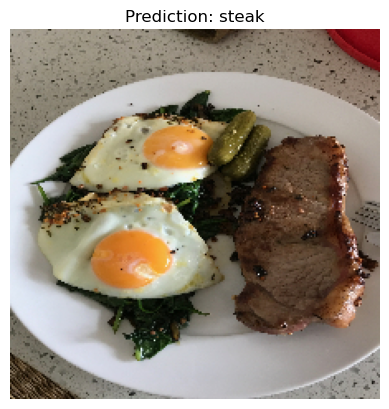

In [73]:
pred_and_plot(model8, "03-steak.jpeg", class_names)

--2025-01-06 10:45:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg.1’

03-pizza-dad.jpeg.1 100%[===================>]   2.74M  11.3KB/s    in 4m 36s  

2025-01-06 10:50:25 (10.2 KB/s) - ‘03-pizza-dad.jpeg.1’ saved [2874848/2874848]



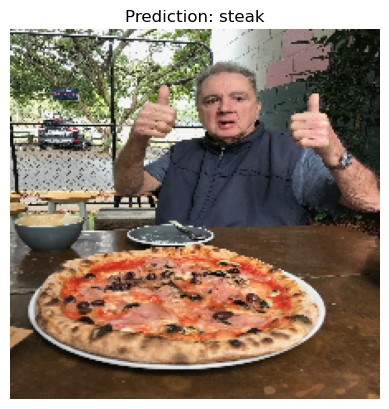

In [ ]:
if not os.path.exists("03-pizza-dad.jpeg"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg 
pred_and_plot(model8, "03-pizza-dad.jpeg", class_names)

## Multi-class Classification 多分类

How about we go through those steps again, except this time, we'll work with 10 different types of food.

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/misc-tensorflow-workflow-outline.png)
*The workflow we're about to go through is a slightly modified version of the above image. As you keep going through deep learning problems, you'll find the workflow above is more of an outline than a step-by-step guide.*

### 1. Import and become one with the data  熟悉数据

Again, we've got a subset of the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101). In addition to the pizza and steak images, we've pulled out another eight classes.


In [ ]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
c
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [90]:
import os

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.

In [91]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [92]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (384, 512, 3)


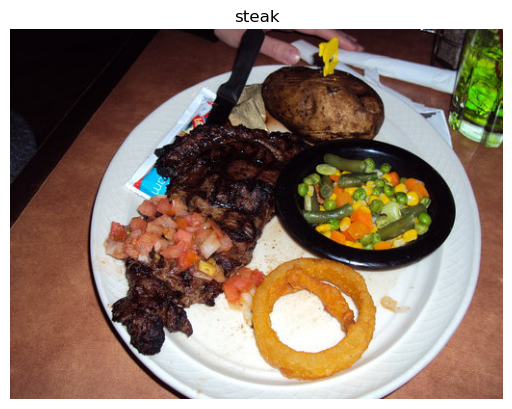

In [93]:
# View a random image from the training dataset
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

### 2. Preprocess the data (prepare it for a model)  处理数据

After going through a handful of images (it's good to visualize at least 10-100 different examples), it looks like our data directories are setup correctly.

Time to preprocess the data.

In [99]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=64,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=64,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 3. Create a model (start with a baseline)

We can use the same model (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

Namely:
* Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
* Changing the output layer to use `'softmax'` activation instead of `'sigmoid'` activation.
* Changing the loss function to be `'categorical_crossentropy'` instead of `'binary_crossentropy'`.

In [100]:
### 3. Create a model (start with a baseline)
model9 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation='softmax'),
])

model9.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])



### 4. Fit a model

Now we've got a model suited for working with multiple classes, let's fit it to our data.

In [101]:
history9 = model9.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data))

Epoch 1/10
118/118 [==============================] - 101s 854ms/step - loss: 2.1349 - accuracy: 0.2253 - val_loss: 1.9644 - val_accuracy: 0.2896
Epoch 2/10
118/118 [==============================] - 101s 852ms/step - loss: 1.8650 - accuracy: 0.3580 - val_loss: 1.8953 - val_accuracy: 0.3552
Epoch 3/10
118/118 [==============================] - 103s 871ms/step - loss: 1.5796 - accuracy: 0.4675 - val_loss: 1.8976 - val_accuracy: 0.3476
Epoch 4/10
118/118 [==============================] - 102s 862ms/step - loss: 1.1459 - accuracy: 0.6257 - val_loss: 2.1819 - val_accuracy: 0.3188
Epoch 5/10
118/118 [==============================] - 103s 878ms/step - loss: 0.6155 - accuracy: 0.8075 - val_loss: 2.7751 - val_accuracy: 0.2936
Epoch 6/10
118/118 [==============================] - 104s 882ms/step - loss: 0.2646 - accuracy: 0.9236 - val_loss: 3.5927 - val_accuracy: 0.2912
Epoch 7/10
118/118 [==============================] - 103s 876ms/step - loss: 0.1019 - accuracy: 0.9753 - val_loss: 4.4452 -

### 5. Evaluate the model

Woohoo! We've just trained a model on 10 different classes of food images, let's see how it went.

In [102]:
# Evaluate on the test data
model9.evaluate(test_data)

40/40 [==============================] - 11s 269ms/step - loss: 6.3154 - accuracy: 0.2760


[6.315359592437744, 0.2759999930858612]

<Axes: >

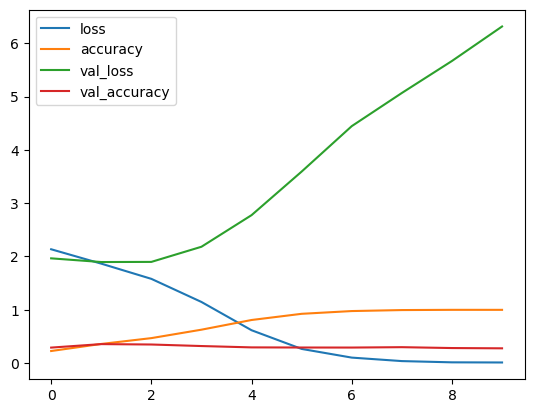

In [103]:
pd.DataFrame(history9.history).plot()

### 6. Adjust the model parameters  调整模型参数

获取更多数据，减少模型参数，数据增强，模型迁移

Due to its performance on the training data, it's clear our model is learning something. However, performing well on the training data is like going well in the classroom but failing to use your skills in real life.

Ideally, we'd like our model to perform as well on the test data as it does on the training data.

So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

- **Get more data** - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
- **Simplify model** - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
- **Use data augmentation** - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
- **Use transfer learning** - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

> 🔑 **Note:** Preventing overfitting is also referred to as **regularization**.

If you've already got an existing dataset, you're probably most likely to try one or a combination of the last three above options first.

Since collecting more data would involve us manually taking more images of food, let's try the ones we can do from right within the notebook.

How about we simplify our model first?

To do so, we'll remove two of the convolutional layers, taking the total number of convolutional layers from four to two.


In [104]:

model10 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation='softmax'),
])

model10.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history10 = model10.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data))


Epoch 1/5
118/118 [==============================] - 53s 443ms/step - loss: 2.2655 - accuracy: 0.2157 - val_loss: 1.9423 - val_accuracy: 0.3060
Epoch 2/5
118/118 [==============================] - 51s 429ms/step - loss: 1.8481 - accuracy: 0.3608 - val_loss: 1.8954 - val_accuracy: 0.3288
Epoch 3/5
118/118 [==============================] - 50s 420ms/step - loss: 1.6176 - accuracy: 0.4607 - val_loss: 1.9331 - val_accuracy: 0.3368
Epoch 4/5
118/118 [==============================] - 53s 444ms/step - loss: 1.3146 - accuracy: 0.5685 - val_loss: 1.9977 - val_accuracy: 0.3272
Epoch 5/5
118/118 [==============================] - 52s 441ms/step - loss: 0.9858 - accuracy: 0.6883 - val_loss: 2.1696 - val_accuracy: 0.3240


<Axes: >

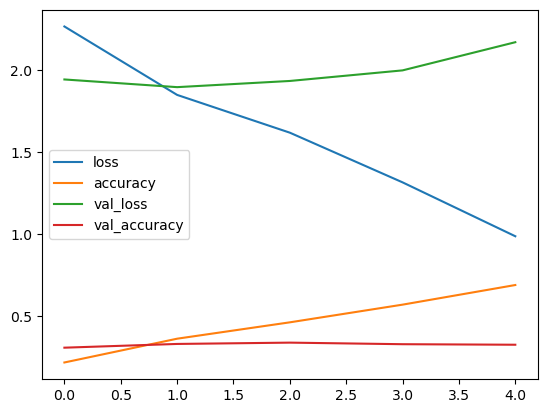

In [105]:
pd.DataFrame(history10.history).plot()

数据效果仍然交差，尝试数据增强，并且使用模型克隆

> 🔑 **Note:** One of the key practices in deep learning and machine learning in general is to **be a serial experimenter**. That's what we're doing here. Trying something, seeing if it works, then trying something else. A good experiment setup also keeps track of the things you change, for example, that's why we're using the same model as before but with different data. The model stays the same but the data changes, this will let us know if augmented training data has any influence over performance.

In [106]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')


Found 7500 images belonging to 10 classes.


In [107]:
model11 = tf.keras.models.clone_model(model10)

model11.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history11 = model11.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data))

Epoch 1/5
118/118 [==============================] - 52s 439ms/step - loss: 2.2404 - accuracy: 0.1977 - val_loss: 2.0247 - val_accuracy: 0.2736
Epoch 2/5
118/118 [==============================] - 50s 424ms/step - loss: 1.8835 - accuracy: 0.3469 - val_loss: 1.9858 - val_accuracy: 0.2896
Epoch 3/5
118/118 [==============================] - 51s 427ms/step - loss: 1.5975 - accuracy: 0.4648 - val_loss: 1.9558 - val_accuracy: 0.3152
Epoch 4/5
118/118 [==============================] - 53s 450ms/step - loss: 1.2276 - accuracy: 0.6044 - val_loss: 2.1725 - val_accuracy: 0.3056
Epoch 5/5
118/118 [==============================] - 52s 441ms/step - loss: 0.8832 - accuracy: 0.7269 - val_loss: 2.4619 - val_accuracy: 0.2904


<Axes: >

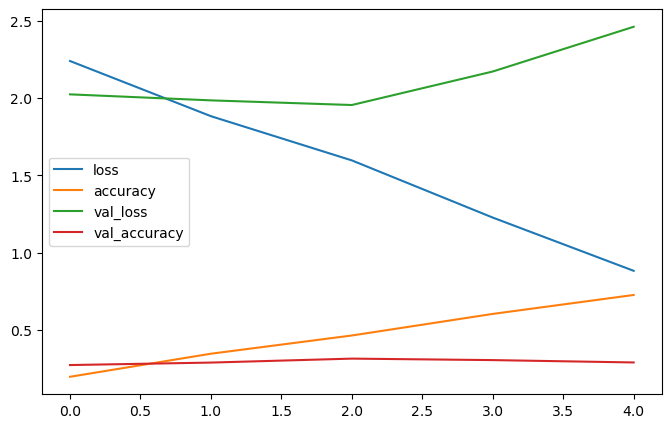

In [108]:
pd.DataFrame(history11.history).plot(figsize=(8, 5))

### 7. Repeat until satisfied

We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer. But as you could image, this could take a fairly long time.

Good thing there's still one trick we haven't tried yet and that's **transfer learning**.

However, we'll save that for the next notebook where you'll see how rather than design our own models from scratch we leverage the patterns another model has learned for our own task.

In the meantime, let's make a prediction with our trained multi-class model.

## Making a prediction with our trained model  模型预测

In [109]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [ ]:
# -q is for "quiet"
if not os.path.exists("03-pizza-dad.jpeg"):
    !wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
if not os.path.exists("03-steak.jpeg"):
    !wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
if not os.path.exists("03-hamburger.jpeg"):
    !wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
if not os.path.exists("03-sushi.jpeg"):
    !wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

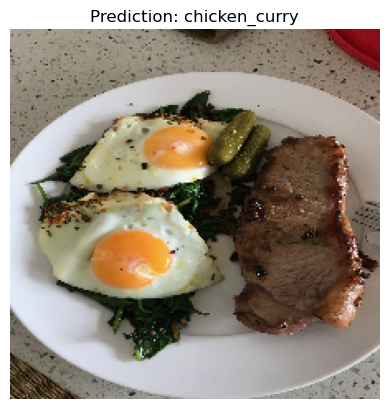

In [111]:
pred_and_plot(model=model11, 
              filename="03-steak.jpeg", 
              class_names=class_names)

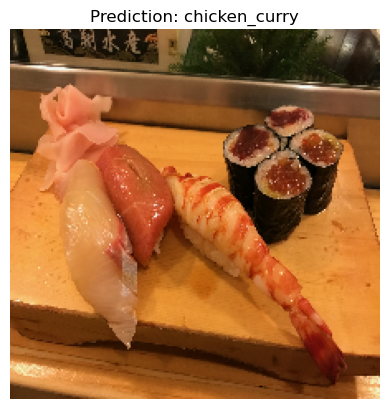

In [112]:
pred_and_plot(model11, "03-sushi.jpeg", class_names)

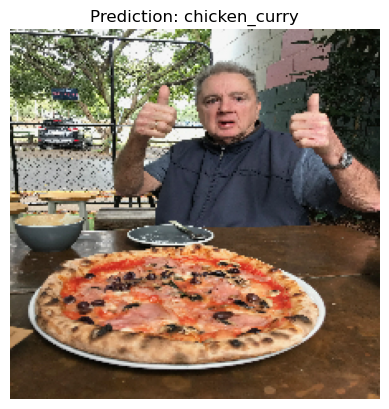

In [113]:
pred_and_plot(model11, "03-pizza-dad.jpeg", class_names)

预测错误，pred_and_plot函数有问题，是预测二分类模型，不是多分类模型

(-0.5, 223.5, 223.5, -0.5)

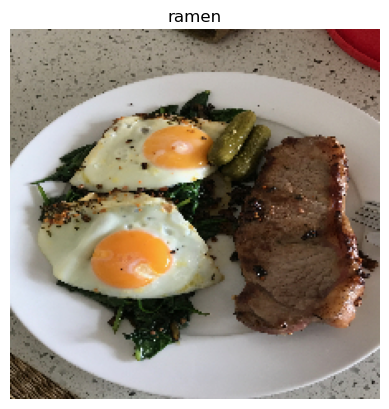

In [114]:
img = load_and_prep_image("03-steak.jpeg")

# Make a prediction
pred = model11.predict(tf.expand_dims(img, axis=0))

# Match the prediction class to the highest prediction probability
pred_class = class_names[pred.argmax()]
plt.imshow(img)
plt.title(pred_class)
plt.axis(False)

In [115]:
# 最大的不同，是预测值的不同，多分类的值是多个,二分类的值是一个
pred = model11.predict(tf.expand_dims(img, axis=0))
pred

array([[0.00135771, 0.00284327, 0.01228423, 0.11534747, 0.02789862,
        0.25996795, 0.00335884, 0.39581862, 0.05641747, 0.1247058 ]],
      dtype=float32)

In [116]:
class_names[pred.argmax()]

'ramen'

In [117]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

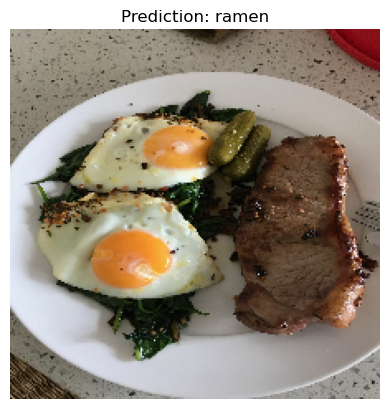

In [118]:
pred_and_plot(model11, "03-steak.jpeg", class_names)

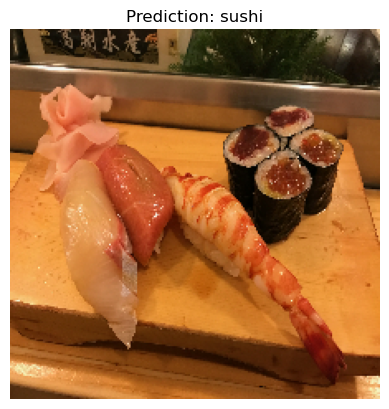

In [119]:
pred_and_plot(model11, "03-sushi.jpeg", class_names)

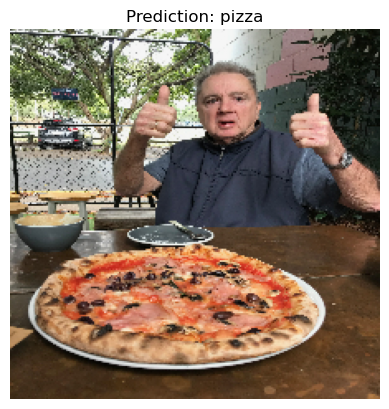

In [120]:
pred_and_plot(model11, "03-pizza-dad.jpeg", class_names)

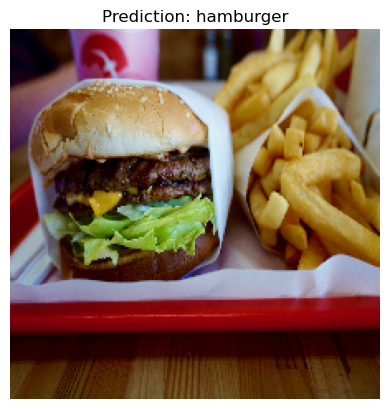

In [121]:
pred_and_plot(model11, "03-hamburger.jpeg", class_names)

## Saving and loading our model

Once you've trained a model, you probably want to be able to save it and load it somewhere else.

To do so, we can use the [`save`](https://www.tensorflow.org/tutorials/keras/save_and_load) and [`load_model`](https://www.tensorflow.org/tutorials/keras/save_and_load) functions.

In [122]:
model11.save('saved_model11')

2025-01-06 11:45:54.270949: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model11/assets


In [124]:
load_model11 = tf.keras.models.load_model('saved_model11')
load_model11.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 111, 111, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 29160)             0         
                                                                 
 dense_18 (Dense)            (None, 10)              

In [125]:
load_model11.evaluate(test_data)

40/40 [==============================] - 10s 244ms/step - loss: 2.4619 - accuracy: 0.2904


[2.4618756771087646, 0.2903999984264374]

In [126]:
model11.evaluate(test_data)

40/40 [==============================] - 10s 244ms/step - loss: 2.4619 - accuracy: 0.2904


[2.4618754386901855, 0.2903999984264374]

## 🛠 Exercises

1. Spend 20-minutes reading and interacting with the [CNN explainer website](https://poloclub.github.io/cnn-explainer/). 
 * What are the key terms? e.g. explain convolution in your own words, pooling in your own words

2. Play around with the "understanding hyperparameters" section in the [CNN explainer](https://poloclub.github.io/cnn-explainer/) website for 10-minutes.
  * What is the kernel size?
  * What is the stride? 
  * How could you adjust each of these in TensorFlow code?

3. Take 10 photos of two different things and build your own CNN image classifier using the techniques we've built here.

4. Find an ideal learning rate for a simple convolutional neural network model on your the 10 class dataset.

## 📖 Extra-curriculum

1. **Watch:** [MIT's Introduction to Deep Computer Vision](https://www.youtube.com/watch?v=iaSUYvmCekI&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=3) lecture. This will give you a great intuition behind convolutional neural networks.

2. **Watch:** Deep dive on [mini-batch gradient descent](https://youtu.be/-_4Zi8fCZO4) by deeplearning.ai. If you're still curious about why we use **batches** to train models, this technical overview covers many of the reasons why.

3. **Read:** [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/convolutional-networks/) class notes. This will give a very deep understanding of what's going on behind the scenes of the convolutional neural network architectures we're writing. 

4. **Read:** ["A guide to convolution arithmetic for deep learning"](https://arxiv.org/pdf/1603.07285.pdf). This paper goes through all of the mathematics running behind the scenes of our convolutional layers.

5. **Code practice:** [TensorFlow Data Augmentation Tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation). For a more in-depth introduction on data augmentation with TensorFlow, spend an hour or two reading through this tutorial.